In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy 
import json

from scipy.spatial.distance import pdist, squareform

Text(0.5, 1.0, 'Population of North Carl, N=1000')

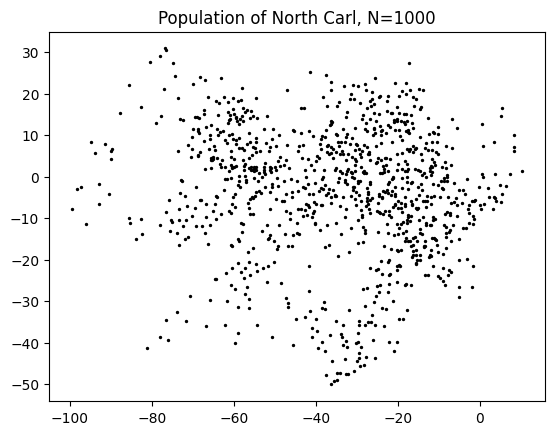

In [2]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[5]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [3]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))]) # x-y coordinates of houses
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]]) # position of the ith antenna
        for j in range(len(placement)):
            coord_j = np.array([placement[j]]) # position of the jth antenna
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist: # checking whether distance between ith and jth < 2R
                    cost += -B # penalising the cost function.


        dist = scipy.spatial.distance.cdist(coord_i, coords) # checking the distance between ith antenna and all houses.
        cov = np.sum(dist < R_dist) # checking whether the distance < R
        cost += cov # maximising cost function

    if cost < 0:
        return -np.inf
    else:
        return cost

## Generating Lattice

In [3]:
# triangular lattice

def generate_triangular_grid(side_lengths, spacing, offset):
    rows, cols = side_lengths
    points = []
    for row in range(rows):
        for col in range(cols):
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points

In [27]:

# Example usage:
R_antennas = 25
spacing = R_antennas*1.5 #this is arbitrary - you can try bigger and smaller grids!
offset = (x.min(), y.min()+30)
#side_lengths = (int(np.ceil((x.max() - x.min())/spacing)), int(np.ceil((y.max() - y.min())/spacing)))
side_lengths=(2,3)
grid_points = generate_triangular_grid(side_lengths = side_lengths, spacing = spacing, offset = offset) 

Text(0.5, 1.0, 'Population of North Carl, N=1000')

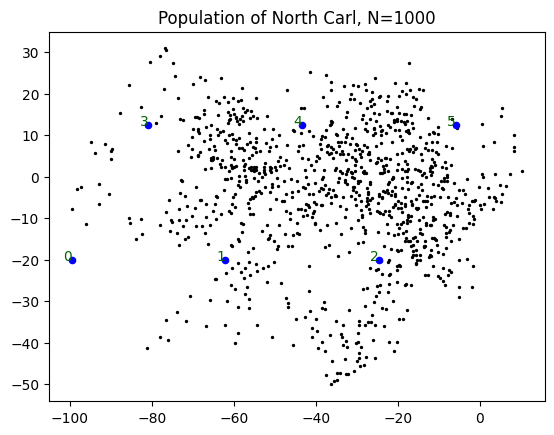

In [28]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
x1 = np.array(grid_points)[:,0]
y1 = np.array(grid_points)[:,1]
plt.scatter(x, y, s=2, facecolor='black')
plt.scatter(x1, y1, s=20, facecolor='blue')
for i, (w, z) in enumerate(zip(x1, y1)):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')

plt.title('Population of {}, N={}'.format(city_name, len(x)))

In [29]:
z_coverage = np.zeros(len(grid_points))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(grid_points)):
    # val_y = y_test[i,j]
    start = np.array(grid_points[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

## finding maximum independent set Heuristically

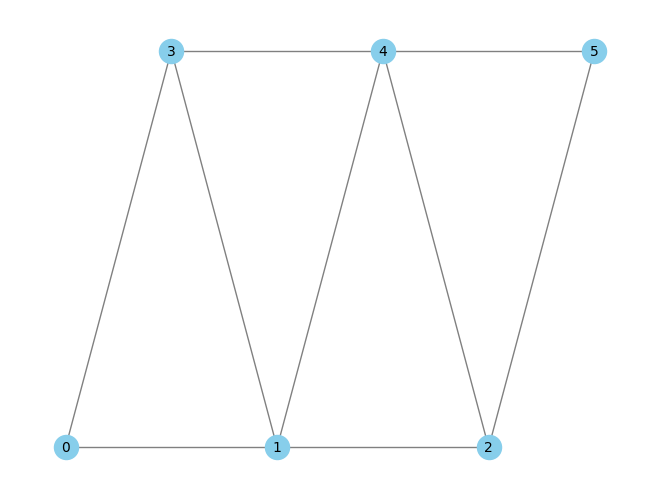

In [30]:
import networkx as nx

pairwise_dist = pdist(np.array(grid_points))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(grid_points):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(grid_points)):
    for j in range(i + 1, len(grid_points)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)

G

In [31]:
import pulp

# Define ILP problem
prob = pulp.LpProblem("MaxWeightedIndependentSet", pulp.LpMaximize)

# Define binary variables for each node
node_vars = {i: pulp.LpVariable(f"x_{i}", cat="Binary") for i in G.nodes()}

# Objective function: Maximize the sum of weights for selected nodes
prob += pulp.lpSum(G.nodes[i]["weight"] * node_vars[i] for i in G.nodes())

# Constraints: Ensure that no two adjacent nodes are both selected
for u, v in G.edges():
    prob += node_vars[u] + node_vars[v] <= 1

# Solve the ILP
prob.solve()

# Extract the solution
independent_set = [i for i in G.nodes() if pulp.value(node_vars[i]) == 1]
total_weight = sum(G.nodes[i]["weight"] for i in independent_set)

print("Maximum Weighted Independent Set:", independent_set)
print("Total Weight:", total_weight)

nil_string = np.zeros(len(G), dtype=int)
for v in independent_set:
    nil_string[v] = 1
ind_bitstring = ''.join([str(i) for i in nil_string])
print("Heuristic bitstring: ", ind_bitstring) 

Maximum Weighted Independent Set: [2, 3]
Total Weight: 562.0
Heuristic bitstring:  001100


If we are finding maximum independent set:

## QUBO formulation of QAOA

In [32]:
adj_mtrx = nx.adjacency_matrix(G)
adj_mtrx.todense()

array([[0, 1, 0, 1, 0, 0],
       [1, 0, 1, 1, 1, 0],
       [0, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 0],
       [0, 1, 1, 1, 0, 1],
       [0, 0, 1, 0, 1, 0]], dtype=int32)

QUBO formulation of the MIS problem:

$$min(-\sum_{i}x_{i}+\alpha\sum_{i<j}x_{i}x_{j})$$ 

where $\alpha>1$. Let's take alpha = 1000 (as given in the evaluate_coverage function).

In [33]:
# Constructing QUBO Matrix
diagonal_elements = -1*np.diag(z_coverage)*np.eye(adj_mtrx.shape[0])
print('diagonal_elements',diagonal_elements)

alpha = 1000
offdiagonal_elements = alpha*adj_mtrx.todense()
print('offdiagonal_elements', offdiagonal_elements)

diagonal_elements [[ -13.   -0.   -0.   -0.   -0.   -0.]
 [  -0. -219.   -0.   -0.   -0.   -0.]
 [  -0.   -0. -411.   -0.   -0.   -0.]
 [  -0.   -0.   -0. -151.   -0.   -0.]
 [  -0.   -0.   -0.   -0. -429.   -0.]
 [  -0.   -0.   -0.   -0.   -0. -293.]]
offdiagonal_elements [[   0 1000    0 1000    0    0]
 [1000    0 1000 1000 1000    0]
 [   0 1000    0    0 1000 1000]
 [1000 1000    0    0 1000    0]
 [   0 1000 1000 1000    0 1000]
 [   0    0 1000    0 1000    0]]


In [34]:
qubo = diagonal_elements+offdiagonal_elements
print(qubo)

[[ -13. 1000.    0. 1000.    0.    0.]
 [1000. -219. 1000. 1000. 1000.    0.]
 [   0. 1000. -411.    0. 1000. 1000.]
 [1000. 1000.    0. -151. 1000.    0.]
 [   0. 1000. 1000. 1000. -429. 1000.]
 [   0.    0. 1000.    0. 1000. -293.]]


In [35]:
# Defining MWIS Cost Function
## Get cost based on Q matix
def get_cost_Q(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

## Get avergae cost
def get_avg_cost(counter, Q):
    cost = sum(counter[key] * get_cost_Q(key, Q) for key in counter)
    return cost / sum(counter.values())


## Mapping problem in NAQC

In [36]:
# Pulser imports
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice,DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from pulser_simulation import QutipEmulator, SimConfig

from scipy.optimize import minimize

In [52]:
# Create a UD graph embedding using appropriate coordinates
coords = np.array(grid_points)
val = np.min(pdist(coords))
coords *= 4/val # normalising the distance:
                    # 4 - denotes minimum distance between atoms in pasqal device 
                    # spacing is the minimum distance between nodes in a graph.

In [53]:
device_used = DigitalAnalogDevice
seed = 100

In [54]:
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
print(Q)

[[   0.         1323.28089111   20.67626392 1323.28089111   49.01040337
     3.85796178]
 [1323.28089111    0.         1323.28089111 1323.28089111 1323.28089111
    49.01040337]
 [  20.67626392 1323.28089111    0.           49.01040337 1323.28089111
  1323.28089111]
 [1323.28089111 1323.28089111   49.01040337    0.         1323.28089111
    20.67626392]
 [  49.01040337 1323.28089111 1323.28089111 1323.28089111    0.
  1323.28089111]
 [   3.85796178   49.01040337 1323.28089111   20.67626392 1323.28089111
     0.        ]]


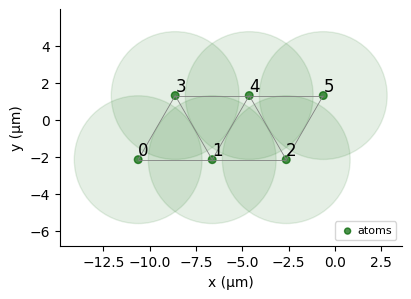

In [55]:
# Cretae a Register on NAQC
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius = device_used.rydberg_blockade_radius(2*R_antennas),
    draw_graph = True,
    draw_half_radius = True, 
)

In [56]:
# Number of layers
layers = 2
omega = 2 * np.pi
detuning = 10

# Define sequence with two pulses
seq = Sequence(reg, device_used)
seq.declare_channel("ch0", "rydberg_global")

# Define variables for sequence of pulses
t_list = seq.declare_variable("t_list", size=layers) 
s_list = seq.declare_variable("s_list", size=layers)

for t, s in zip(t_list, s_list):
    pulse1 = Pulse.ConstantPulse(200 * t, omega, 0.0, 0) # omega - transverse field term
    pulse2 = Pulse.ConstantPulse(200 * s, 0.0, detuning, 0) # detuning - sigmaz term

    seq.add(pulse1, "ch0")
    seq.add(pulse2, "ch0")

seq.measure("ground-rydberg")

In [57]:
# Define a quantum loop that runs these sequences
def quantum_loop(params):
    params = np.array(params)
    t_params, s_params = np.reshape(params.astype(int), (2, layers))

    sample_sequence = seq.build(t_list=t_params, s_list=s_params)
    simulate = QutipEmulator.from_sequence(sample_sequence, sampling_rate=0.01) #
    results = simulate.run()

    count_dict = results.sample_final_state(N_samples = 100)
    return count_dict

In [58]:
# Main function that runs the pulses, obtains samples, and calcualtes the avg cost
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_avg_cost(C, Q)
    return cost

In [60]:
optimal_count_dict = quantum_loop(params[-1])
print(optimal_count_dict)

Counter({'000000000': 28, '001000100': 15, '000010000': 11, '000001000': 10, '010000000': 8, '100000001': 8, '000000010': 6, '100001000': 5, '000000001': 2, '000001100': 2, '100000000': 2, '000000100': 1, '000100000': 1, '100000010': 1})


In [59]:
scores = []
params = []

for repetition in range(5):


    guess = {
        "t": np.random.uniform(1, 10, layers),
        "s": np.random.uniform(1, 10, layers),
    }

    iteration = 0
    def callback(xk):
        global iteration
        global scores
        global params

        score = func(xk, qubo)
        scores.append(score)
        params.append(xk)
        print(f"Iteration {iteration}: x = {xk}")
        iteration += 1

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
            callback = callback,
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

Iteration 0: x = [6.02098139 1.37333215 1.00491852 4.1065658 ]
Iteration 1: x = [6.02098139 1.37333215 1.00491852 4.1065658 ]
Iteration 2: x = [6.02098139 1.37333215 1.00491852 4.1065658 ]
Iteration 0: x = [2.36930793 5.00898512 4.67406635 6.54983707]
Iteration 1: x = [2.36930793 5.00898512 4.67406635 6.54983707]
Iteration 2: x = [2.36930793 5.00898512 4.67406635 6.54983707]
Iteration 3: x = [2.36208443 4.93262864 4.51731413 6.50674603]
Iteration 4: x = [2.36208443 4.93262864 4.51731413 6.50674603]
Iteration 5: x = [2.36208443 4.93262864 4.51731413 6.50674603]
Iteration 6: x = [2.36208443 4.93262864 4.51731413 6.50674603]
Iteration 7: x = [2.36208443 4.93262864 4.51731413 6.50674603]
Iteration 8: x = [2.36208443 4.93262864 4.51731413 6.50674603]
Iteration 0: x = [7.05678739 7.16260142 4.89327619 6.45126309]
Iteration 1: x = [7.05678739 7.16260142 4.89327619 6.45126309]
Iteration 2: x = [7.05678739 7.16260142 4.89327619 6.45126309]
Iteration 3: x = [7.05678739 7.16260142 4.89327619 6.29

In [63]:
indx = np.argmin(scores)
param = params[indx]

optimal_count_dict = quantum_loop(param)
print(optimal_count_dict)

Counter({'000000': 22, '100000': 16, '001000': 14, '000100': 12, '000010': 9, '100001': 9, '000001': 7, '010000': 7, '101000': 2, '000101': 1, '010001': 1})


In [81]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
print(optimal_count_dict)
print(optimal_count_dict['0010001'])

Counter({'0011000': 14, '0000001': 11, '0011100': 9, '1001100': 8, '0110000': 7, '0111000': 7, '1000000': 6, '0010001': 5, '0001000': 4, '0101000': 4, '1001000': 4, '1010010': 4, '1100010': 3, '0001100': 2, '0010010': 2, '1010000': 2, '1011000': 2, '0100000': 1, '0100010': 1, '1000100': 1, '1011100': 1, '1100000': 1, '1110010': 1})
5


In [83]:
get_cost_Q(list(optimal_count_dict.keys())[0],qubo)

-501.0